In [8]:
# example string to do mini tests on
example = "I just EASILY had the BEST lunch I've ever eaten!  It was THAT good!\n\nThe chicken tortilla soup was out of this world...light and delicate...fresh and HOT!!!\nI had two fish tacos with no tortilla.  One was a regular fish taco and the other was a beer battered fish taco.l\n\nThe fire roasted salsa was EASILY the best salsa I have ever had, too!\n\nThis place is a serious gem!  I could go there every single day!\n\nThanks guys!!"

# Import Benepar


In [9]:
import benepar
benepar.download("benepar_en2")
parser = benepar.Parser("benepar_en2")

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

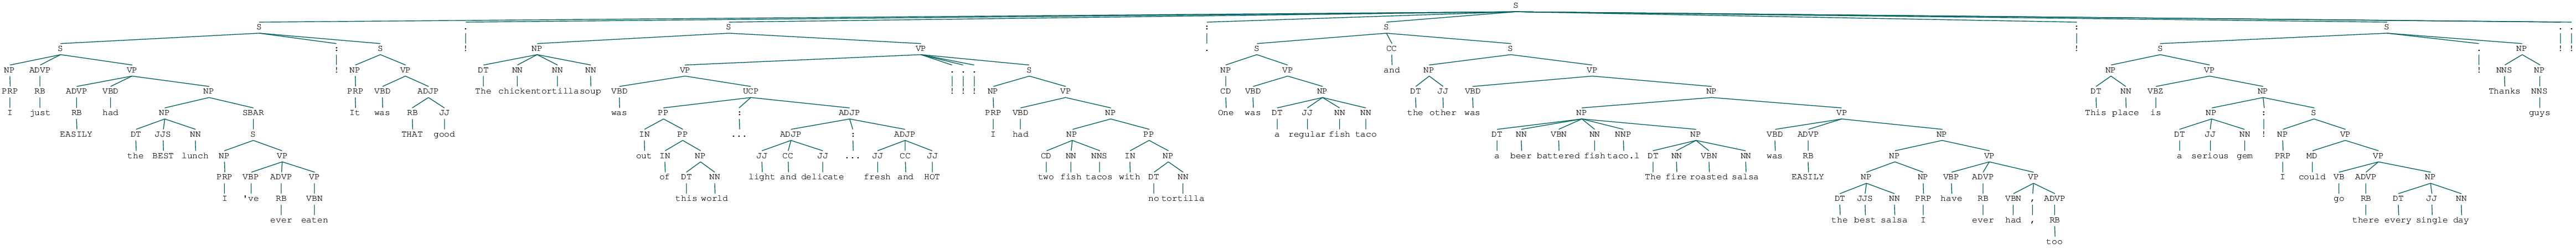

In [3]:
parser.parse(example)

# Import StanfordNLP

Remember to first instantiate stanfordNLP in java!

java command: 

``
java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -annotators "tokenize,ssplit,pos,lemma,parse,sentiment" -sentiment.threads 8 -port 9000 -timeout 30000``


In [10]:
import stanfordnlp
from stanfordcorenlp import StanfordCoreNLP
import logging
import json

class StanfordNLP:
    def __init__(self, host='http://localhost', port=9000):
        self.nlp = StanfordCoreNLP(host, port=port,
                                   timeout=30000)  # , quiet=False, logging_level=logging.DEBUG)
        self.props = {
            'annotators': 'tokenize,ssplit,pos,lemma,ner,parse,depparse,dcoref,relation',
            'pipelineLanguage': 'en',
            'outputFormat': 'json'
        }

    def word_tokenize(self, sentence):
        return self.nlp.word_tokenize(sentence)

    def pos(self, sentence):
        return self.nlp.pos_tag(sentence)

    def ner(self, sentence):
        return self.nlp.ner(sentence)

    def parse(self, sentence):
        return self.nlp.parse(sentence)

    def dependency_parse(self, sentence):
        return self.nlp.dependency_parse(sentence)

    def annotate(self, sentence):
        return json.loads(self.nlp.annotate(sentence, properties=self.props))

    @staticmethod
    def tokens_to_dict(_tokens):
        tokens = defaultdict(dict)
        for token in _tokens:
            tokens[int(token['index'])] = {
                'word': token['word'],
                'lemma': token['lemma'],
                'pos': token['pos'],
                'ner': token['ner']
            }
        return tokens

    

sNLP = StanfordNLP()
text = 'A blog post using Stanford CoreNLP Server. Visit www.khalidalnajjar.com for more details.'
print("Parse:", sNLP.parse(text))

Parse: (ROOT
  (S
    (NP (DT A) (NN blog))
    (VP (NN post)
      (S
        (VP (VBG using)
          (NP (NNP Stanford) (NNP CoreNLP) (NN Server)))))
    (. .)))


# Import Entity Recognition Model

In [11]:
import spacy

model_dir = "./models"
nlp = spacy.load(model_dir)

In [7]:
nlp.to_disk("./temp/model")

In [12]:
def get_entities(nlp_model, text):
    """
    Input nlp_model and text, retrieve a list of unique entities from the text.
    """
    doc = nlp_model(text)
    entities = set()
    for ent in doc.ents:
        if ent.label_ == "PRODUCT":
            entities.add(ent.text)
    return list(entities)

In [13]:
example_entity_list = get_entities(nlp, example)
example_entity_list

['place',
 'fish',
 'taco',
 'beer',
 'gem',
 'tortilla',
 'lunch',
 'soup',
 'salsa',
 'chicken']

In [14]:
example

"I just EASILY had the BEST lunch I've ever eaten!  It was THAT good!\n\nThe chicken tortilla soup was out of this world...light and delicate...fresh and HOT!!!\nI had two fish tacos with no tortilla.  One was a regular fish taco and the other was a beer battered fish taco.l\n\nThe fire roasted salsa was EASILY the best salsa I have ever had, too!\n\nThis place is a serious gem!  I could go there every single day!\n\nThanks guys!!"

# Sentiment Helper Code

In [15]:
import collections

def remove_nestings(lst): 
    output = []
    
    def remove_nestings_recursive(l):
        for i in l: 
            if type(i) == list: 
                remove_nestings_recursive(i) 
            else: 
                output.append(i)
    
    remove_nestings_recursive(lst)
    
    return output

def continue_splitting(review,list_of_dividers):
        
    temp = list_of_dividers.copy()
    l = [review]
    while len(temp) > 0:
        divider = temp.pop(0)
        l_new = []
        for i in l:
            l_new += i.split(divider)
        l = l_new
    return l

def join_clause(review, list_of_split_clauses, list_of_dividers):
    output = []
    loc_of_split_clauses = []
    for clause in list_of_split_clauses:
        loc_of_split_clauses.append(review.find(clause))
    for divider in list_of_dividers:
        print(divider)
        loc_div = review.find(divider)
        print(loc_div)
        for i in range(len(loc_of_split_clauses)):
            if loc_div > loc_of_split_clauses[i]:
                print(loc_div,loc_of_split_clauses[i])
                
def join_partitions(long_review,entity_with_review):
    loclist = []
    for (_, clause) in entity_with_review:
        loclist.append((long_review.find(clause),long_review.find(clause)+len(clause)))
    starts = {i for (i,j) in loclist}
    ends = {j for (i,j) in loclist}
    starts.add(len(long_review))
    newends = {}
    for i in ends:
        newends[i] = min([x for x in starts if x >= i])
    for i in newends:
        pass
    new_entity_with_review = []
    for i in range(len(loclist)):
        tup = loclist[i]
        entity = entity_with_review[i][0]
        st = tup[0]
        en = newends[tup[1]]
        new_entity_with_review.append((entity,long_review[st:en]))
    return new_entity_with_review

def split_long_string(review):
    num = len(review)
    split_list = []
    start = 0
    end = 0
    while num != end:
        if num - end < 1000:
            end = num
            split_list.append(review[start:end])
        else:
            end = review[start:(start+1000)].rfind('.')
            if end == -1:
                end = review[start:(start+1000)].rfind(' ') #if no '.', space will do
                if end == -1:
                    end = min(start + 1000,num)
            split_list.append(review[start:end])
            start = end
    print(start,end)
    return(split_list)

def min_tree(review, entities, parser, output = 'minimum'):
    
    full_review = ''
    #review is string, entities is list of strings, parser is parser object
    # TODO: How well are each review punctuatd and so forth EDA
    if output == 'partition':
        full_review = ''
    
    # NOT SURE WHAT FULL REVIEW IS 
    
    treelist = []
    lenlist = []
    temp = review.split('\n')
    
    
    #long_reviews = [i.split('.') for i in temp if len(i) > 1000] #TODO: add ! and ? #TODO find better split rule
    #long_reviews = remove_nestings(long_reviews)
    #short_reviews = [i for i in temp if len(i) > 1 and len(i) <= 1000 ]
    #split_reviews = long_reviews + short_reviews
    
    if len(review) > 1000:
        split_reviews = split_long_string(review)
    else:
        split_reviews = [i for i in temp if len(i) > 1 and len(i) <= 1000 ]
    
    for rev in split_reviews:
        if rev and rev.strip():
            u = parser.parse(rev) # tree 

            if type(u) == str:
                u = nltk.Tree.fromstring(u)

            for s in u.subtrees(): # subtrees 
                    if s.label() == 'S': # if sentence
                        treelist += [s]
                        lenlist += [len(s.leaves())] # how long clause
                        
            if output == 'partition':
                full_review += ' '.join(u.leaves())

    treelist = [x for _, x in sorted(zip(lenlist,treelist),reverse=False)] # sort by lenlisit
    clauses = [' '.join(tree.leaves()) for tree in treelist]
    if not clauses:
        clauses.append(full_review)
    
    entity_with_clause = []
    
    if output == 'all':
        for entity in entities:
            clauselist = []
            for clause in clauses:
                if entity in clause:
                    clauselist.append(clause)
            entity_with_clause.append((entity,clauselist))
    
    #TODO: create rules and test them
    elif output == 'minimum':
        for entity in entities:
            for clause in clauses:
                if entity in clause:
                    entity_with_clause.append((entity,clause))
                    break
                    
    elif output == 'partition':
        #first find minimal clause
        for entity in entities:
            for clause in clauses:
                if entity in clause:
                    entity_with_clause.append((entity,clause))
                    break
        #get location of minimal clause in review
        
        
        entity_with_clause = join_partitions(full_review,entity_with_clause)
    
    return entity_with_clause

# Code to Perform Sentiment Analysis

In [16]:
#STANFORD NLP
def stanford_sentiment(entity_with_clause):
#     stanford_sentiment_start()
    entity_with_sentiment = []
    for entity, clause in entity_with_clause:
        result = nlp.annotate(clause,
                   properties={
                       'annotators': 'sentiment',
                       'outputFormat': 'json'
                   })
        sentiment = np.dot(result['sentences'][0]['sentimentDistribution'], [-2, -1, 0, 1, 2])
        entity_with_sentiment.append((entity, sentiment))
    return entity_with_sentiment

#VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def vader_sentiment(entity_with_clause):
    analyzer = SentimentIntensityAnalyzer()
    entity_with_sentiment = []
    for entity, clause in entity_with_clause:
        sentiment = analyzer.polarity_scores(clause)['compound']
        entity_with_sentiment.append((entity,sentiment))
    return(entity_with_sentiment)       

In [11]:
example_min_tree = min_tree(example, example_entity_list, parser)
example_min_tree

[('beer',
  'I had two fish tacos with no tortilla . One was a regular fish taco and the other was a beer battered fish taco.l'),
 ('tortilla', 'I had two fish tacos with no tortilla'),
 ('fish', 'One was a regular fish taco'),
 ('taco', 'One was a regular fish taco'),
 ('lunch', "I just EASILY had the BEST lunch I 've ever eaten"),
 ('salsa',
  'The fire roasted salsa was EASILY the best salsa I have ever had , too !'),
 ('place', 'This place is a serious gem'),
 ('gem', 'This place is a serious gem'),
 ('chicken',
  'The chicken tortilla soup was out of this world ... light and delicate ... fresh and HOT ! ! !'),
 ('soup',
  'The chicken tortilla soup was out of this world ... light and delicate ... fresh and HOT ! ! !')]

In [42]:
# need to fix stanford error here
stanford_sentiment(example_min_tree)

AttributeError: 'English' object has no attribute 'annotate'

In [17]:
def get_vader_scores(text, entity_list, parser):
    tree = min_tree(text, entity_list, parser)
    return vader_sentiment(tree)

get_vader_scores(example, example_entity_list, parser)

[('place', -0.0772),
 ('fish', 0.0),
 ('taco', 0.0),
 ('beer', -0.296),
 ('gem', -0.0772),
 ('tortilla', -0.296),
 ('lunch', 0.8429),
 ('soup', 0.5229),
 ('salsa', 0.7371),
 ('chicken', 0.5229)]

# Perform End-to-End Validation

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# import data
df_raw = pd.read_json("restaurant_reviews_1900k.json", lines=True)

# only get restaurants with many reviews
many_reviews = df_raw[['business_id','review_id']].groupby("business_id")['review_id'].nunique()
many_reviews = many_reviews[many_reviews > 1000].index # more than 100 reviews
df = df_raw[df_raw.business_id.isin(set(many_reviews))]

In [19]:
print("Number of businesses in subset: ", len(df.business_id.unique()))

Number of businesses in subset:  142


In [20]:
# only grab restaurants with 3.5-4.5 stars
business_stars = df[['business_id', 'stars']].groupby('business_id').mean()
business_with_same_stars = business_stars[
    (business_stars.stars > 3.5) 
    & (business_stars.stars < 4.5)].index

In [21]:
# grab only one business as a subset
bus = df[df.business_id == '-6tvduBzjLI1ISfs3F_qTg']

In [22]:
# show average rating for that restaurant
print("Average Ratings: ", np.mean(bus.stars))

Average Ratings:  3.8768844221105527


In [18]:
# initialize spacy model
model_dir = "./models"
nlp = spacy.load(model_dir)

In [23]:
from tqdm.notebook import tqdm
from collections import defaultdict

# get set of entities for this particular restaurant,
# and count how many reviews each entity have
entities_with_count = defaultdict(int) 
review_entities = [] # extract entities for each review
for review in tqdm(bus.text):
    entities = get_entities(nlp, review)
    
    # add this review as a count to an entity
    for ent in entities:
        entities_with_count[ent.lower()] += 1
        
    review_entities.append(entities)

In [24]:
# subset entities that have enough reviews
entities_with_enough_reviews = []

# for now, the threshold is 20
threshold = 20
for key, value in entities_with_count.items():
    if value >= threshold:
        entities_with_enough_reviews.append(key)

In [25]:
# TRUE RANKINGS CALCULATION
# for each entity, average ratings
true_rankings = defaultdict(list)

for entity in entities_with_enough_reviews:
    true_rankings['entity'] += [entity]
    entity_reviews = bus[bus.text.str.contains(entity, case=False)]
    true_rankings['average_stars'] += [np.mean(entity_reviews.stars)]

true_rankings = pd.DataFrame(true_rankings)

In [26]:
# PREDICTION RANKING CALCULATION

# Filter entities attached to each review to be 
# from the one with enough review
entity_filter = set(entities_with_enough_reviews)

filtered_entities = []

for entities in tqdm(review_entities):
    filtered = []
    for ent in entities:
        ent = ent.lower()
        if ent in entity_filter:
            filtered.append(ent)
    filtered_entities.append(filtered)

### NOTE: error was thrown full_review was referenced before initialization. Need to fix!!!!

In [ ]:
predicted_scores = defaultdict(list)

for i, review in enumerate(tqdm(bus.text)):
    entities = filtered_entities[i]
    
    scores = get_vader_scores(review, entities, parser)
    
    # save results 
    for entity, score in scores:
        predicted_scores[entity] += [score]

    print(review)xt
    print(get_vader_scores(review, entities, parser))

In [ ]:
# create rankings from scores
predicted_rankings = defaultdict(list)
for entity, scores in predicted_scores.items():
    predicted_rankings['entity'] += [entity]
    predicted_rankings['predicted_score'] += [np.mean(scores)]

In [ ]:
# combine true and ranking into one table,
# and then calculate spearman correlation score
rankings = true_rankings.join(predicted_rankings, on='entity', how='left')

In [168]:
from scipy.stats import spearmanr
rankings

,entity,average_stars,predicted
0,salad,3.969072,4.694935
1,atmosphere,4.022124,3.188274
2,burrito,3.813793,1.071066
3,food,3.675159,4.760916
4,taco,3.926329,4.733622
5,chicken burrito,3.695652,1.662370
6,chicken taco,3.863636,1.428835
7,carnitas,4.135593,3.772582
8,pork adobada,4.000000,2.369075
9,carne asada,3.826590,3.080352


In [169]:
# spearman correlation metric
corr, pvalue = spearmanr(rankings.average_stars, rankings.predicted_scores)
print("Spearman Correlation: ", corr)

Spearman Correlation:  -0.11042311661506708


In [ ]:
### manual entities to just test out sentiment analysis
# entities = [
#     'salad',
#     'atmosphere', 
#     'burrito',
#     'food',
#     'taco',
#     'chicken burrito',
#     'chicken taco',
#     'carnitas',
#     'pork adobada',
#     'carne asada',
#     'fish taco',
#     'shrimp taco',
#     'chips',
#     'salsa',
#     'beer',
#     'tequila',
#     'margarita',
#     'mojito'
# ]